# Importing relevant modules

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import sklearn.metrics as metrics
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Loading dataset

In [68]:
df = pd.read_csv('saveecobot_4230.csv')
df = df.drop(['value_text'], axis=1)
df.head()

,device_id,phenomenon,value,logged_at
0,4230,aqi,65.0,2020-08-11 23:00:00
1,4230,pm25,18.6,2020-08-11 23:00:00
2,4230,temperature,19.0,2020-08-11 23:00:00
3,4230,humidity,88.0,2020-08-11 23:00:00
4,4230,pressure_pa,101500.0,2020-08-11 23:00:00


# Exploration Data Analysis

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124610 entries, 0 to 124609
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   device_id   124610 non-null  int64  
 1   phenomenon  124610 non-null  object 
 2   value       124610 non-null  float64
 3   logged_at   124610 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.8+ MB


In [70]:
df.describe()

,device_id,value
count,124610.0,124610.000000
mean,4230.0,20351.991925
std,0.0,40626.486865
min,4230.0,-21.000000
25%,4230.0,13.000000
50%,4230.0,47.000000
75%,4230.0,93.000000
max,4230.0,104800.000000


## Cheking for missing values

In [71]:
df.isnull().sum()

device_id     0
phenomenon    0
value         0
logged_at     0
dtype: int64

In [72]:
#print(f'Percentage of "0" entries: {round((df["value"] == 0).sum()/len(df) * 100, 3)} %')

Since the amount of such values are insignificant it's save to delete them.

In [73]:
#df = df[df['value'] != 0]

## Transform dates

In [74]:
df['logged_at'] = pd.to_datetime(df['logged_at'])
df

,device_id,phenomenon,value,logged_at
0,4230,aqi,65.0,2020-08-11 23:00:00
1,4230,pm25,18.6,2020-08-11 23:00:00
2,4230,temperature,19.0,2020-08-11 23:00:00
3,4230,humidity,88.0,2020-08-11 23:00:00
4,4230,pressure_pa,101500.0,2020-08-11 23:00:00
...,...,...,...,...
124605,4230,aqi,12.0,2023-09-05 17:00:00
124606,4230,pm25,3.0,2023-09-05 17:00:00
124607,4230,temperature,24.0,2023-09-05 17:00:00
124608,4230,humidity,43.0,2023-09-05 17:00:00


## Transform pressure values

Since the values of pressure_pa are usually higher than 1000, values for this column should be normalized.

In [75]:
df.loc[df['phenomenon'] == 'pressure_pa', 'value'] /= 1000

In [76]:
df['phenomenon'] = df['phenomenon'].replace({'pressure_pa': 'pressure_kpa'})

Too analize futher, data needs to be group by phenomenon and time.

In [77]:
df['logged_at'] = pd.to_datetime(df['logged_at'])
df['hour'] = df['logged_at'].dt.hour
df['month'] = df['logged_at'].dt.month

In [78]:
phenomenons = list(df['phenomenon'].unique())
colors = ['lightcoral', 'palegreen', 'lightblue', 'plum', 'lightpink']

In [79]:
num_categories = len(phenomenons)
num_cols = 2
num_rows = (num_categories + num_cols - 1) // num_cols
confidence_interval = 0.95

### Relationship between phenomenons and months

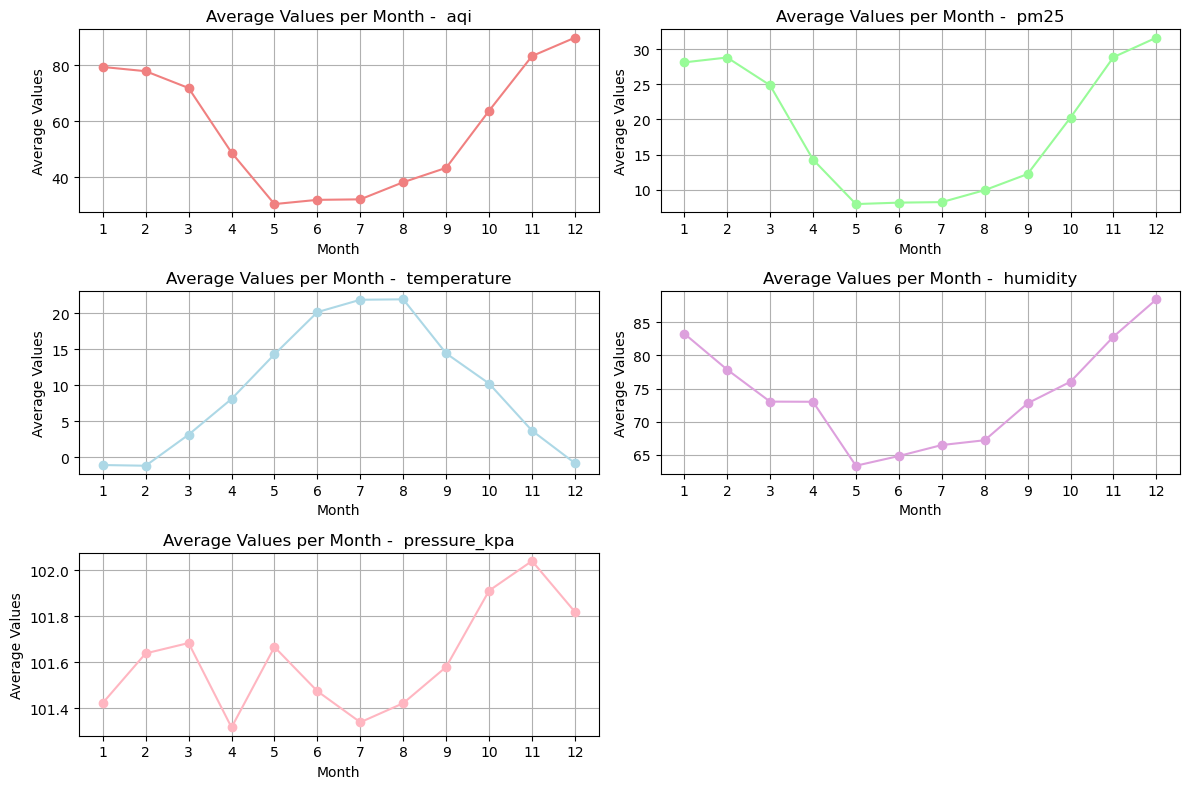

In [80]:

average_values = df.groupby(['phenomenon', 'month'])['value'].mean().reset_index()
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, phenomenon_category in enumerate(phenomenons):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    subset_df = average_values[average_values['phenomenon'] == phenomenon_category]
    ax.plot(subset_df['month'], subset_df['value'], marker='o', color=colors[i % len(colors)])
    ax.set_xlabel('Month')
    ax.set_ylabel('Average Values')
    ax.set_title(f'Average Values per Month -  {phenomenon_category}')
    ax.grid(True)
    ax.set_xticks(range(1, 13))

for i in range(num_categories, num_cols * num_rows):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

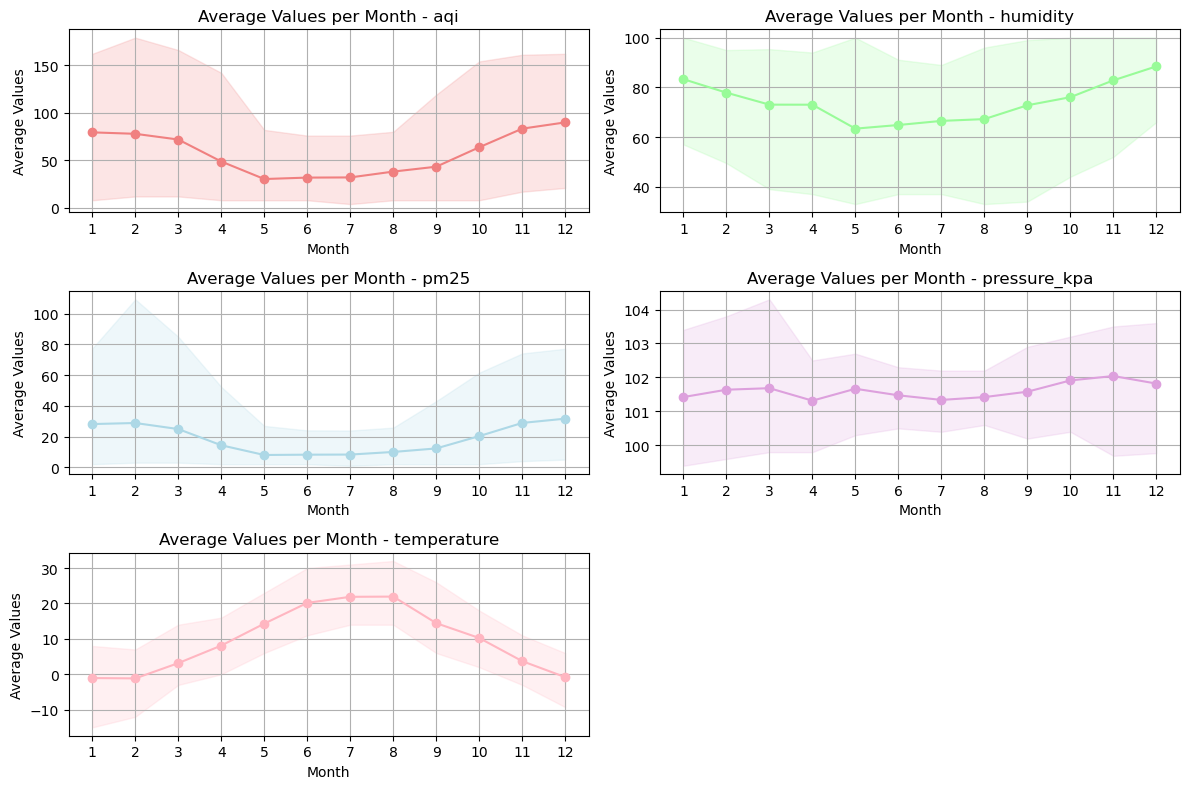

In [81]:
average_values = df.groupby(['phenomenon', 'month'])['value'].agg([np.mean, lambda x: np.percentile(x, q=((1-confidence_interval)*100)/2), lambda x: np.percentile(x, q=100-((1-confidence_interval)*100)/2)]).reset_index()
average_values.columns = ['phenomenon', 'month', 'mean', 'lower_ci', 'upper_ci']


fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, phenomenon_category in enumerate(average_values['phenomenon'].unique()):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    
    subset_df = average_values[average_values['phenomenon'] == phenomenon_category]

    ax.plot(subset_df['month'], subset_df['mean'], marker='o', color=colors[i])
    ax.fill_between(subset_df['month'], subset_df['lower_ci'], subset_df['upper_ci'], color=colors[i], alpha=0.2)
    
    ax.set_xlabel('Month')
    ax.set_ylabel('Average Values')
    ax.set_title(f'Average Values per Month - {phenomenon_category}')
    ax.grid(True)
    ax.set_xticks(range(1, 13))

for i in range(num_categories, num_cols * num_rows):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

It is easy to see that:

1. Aqi is much lower during hot seasons (e. g. it is lowest in may, june, july).
2. Pm25 is much lower during hot seasons (e. g. it is lowest in may, june, july).
3. Aqi might be inversly propotional to temperature.
4. Humidity is much lower during hot seasons (e. g. it is lowest in may, june, july).
5. There are many outliers (except for temperature).
6. **Data might be seasonal**

### Relationship between phenomenons and hours

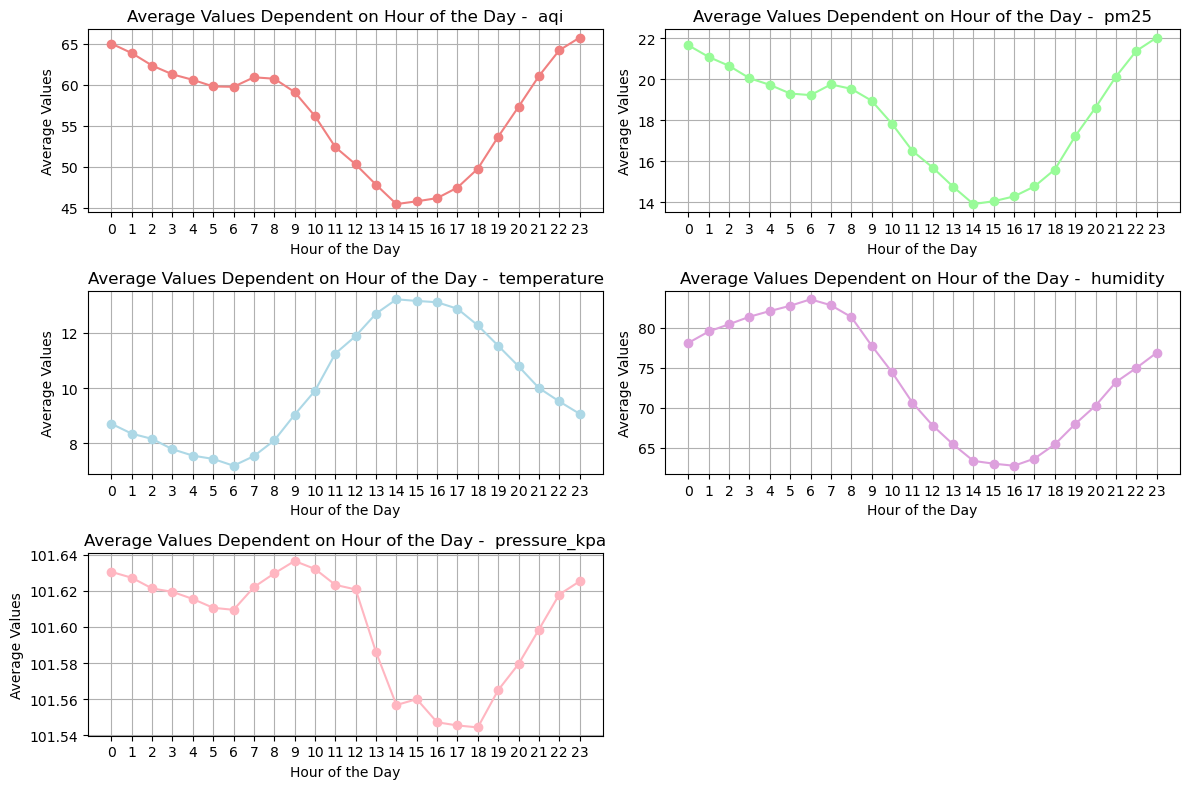

In [82]:
average_values = df.groupby(['phenomenon', 'hour'])['value'].mean().reset_index()
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, phenomenon_category in enumerate(phenomenons):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]

    subset_df = average_values[average_values['phenomenon'] == phenomenon_category]
    ax.plot(subset_df['hour'], subset_df['value'], marker='o', color=colors[i % len(colors)])
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Average Values')
    ax.set_title(f'Average Values Dependent on Hour of the Day -  {phenomenon_category}')
    ax.grid(True)
    ax.set_xticks(range(24))

for i in range(num_categories, num_cols * num_rows):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

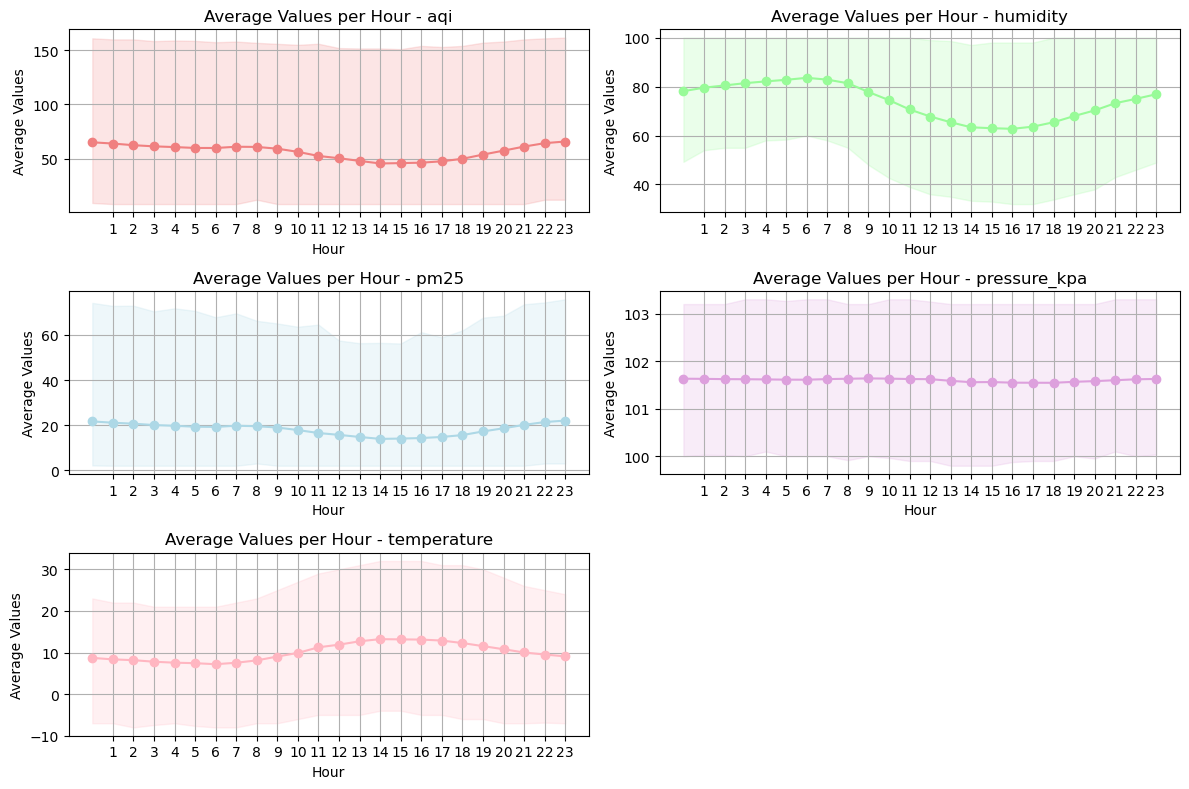

In [83]:
average_values = df.groupby(['phenomenon', 'hour'])['value'].agg([np.mean, lambda x: np.percentile(x, q=((1-confidence_interval)*100)/2), lambda x: np.percentile(x, q=100-((1-confidence_interval)*100)/2)]).reset_index()
average_values.columns = ['phenomenon', 'hour', 'mean', 'lower_ci', 'upper_ci']


fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, phenomenon_category in enumerate(average_values['phenomenon'].unique()):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    
    subset_df = average_values[average_values['phenomenon'] == phenomenon_category]

    ax.plot(subset_df['hour'], subset_df['mean'], marker='o', color=colors[i])
    ax.fill_between(subset_df['hour'], subset_df['lower_ci'], subset_df['upper_ci'], color=colors[i], alpha=0.2)
    
    ax.set_xlabel('Hour')
    ax.set_ylabel('Average Values')
    ax.set_title(f'Average Values per Hour - {phenomenon_category}')
    ax.grid(True)
    ax.set_xticks(range(1, 24))

for i in range(num_categories, num_cols * num_rows):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

It is easy to see that:

1. Aqi is much lower at noon.
2. Pm25 is much lower at noon.
3. Aqi might be inversly propotional to temperature.
4. Humidity is much lower at noon.
5. There are **many many** outliers (except for temperature).
6. **It's not clear if data depends on hour of the day**

# Regression analysis

## Finding correlation

In [84]:
entry_counts = df['phenomenon'].value_counts()
number_of_entries_list = entry_counts.tolist()
entry_counts

aqi             24922
pm25            24922
temperature     24922
humidity        24922
pressure_kpa    24922
Name: phenomenon, dtype: int64

For making correlation matrix values for each phenomenon category needs to be extracted.

In [142]:
df_grouped = df.groupby(['phenomenon', 'logged_at'], as_index=False).aggregate('mean')
grouped_values = df_grouped.groupby('phenomenon')['value'].apply(list)
phenomenon_values = {}

for i in range(len(grouped_values)):
    phenomenon_values[phenomenons[i]] = grouped_values[i]

In [145]:
pd.DataFrame(phenomenon_values).corr()

,aqi,pm25,temperature,humidity,pressure_kpa
aqi,1.000000,0.419061,0.954026,0.171649,-0.490286
pm25,0.419061,1.000000,0.359150,-0.078261,-0.520534
temperature,0.954026,0.359150,1.000000,0.174280,-0.457763
humidity,0.171649,-0.078261,0.174280,1.000000,-0.178342
pressure_kpa,-0.490286,-0.520534,-0.457763,-0.178342,1.000000


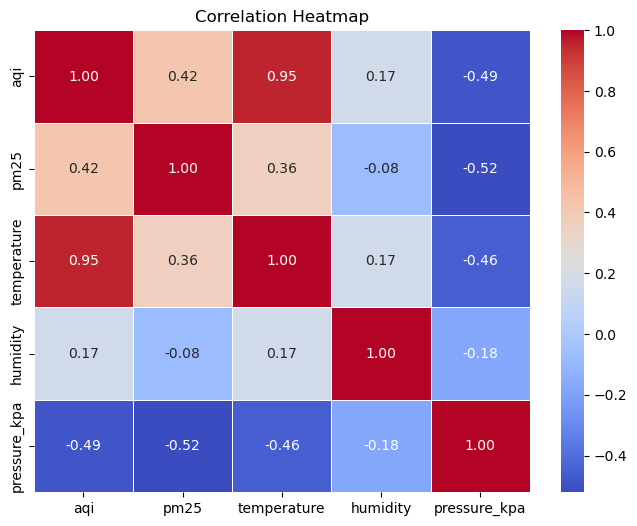

In [89]:
plt.figure(figsize=(8, 6))
sns.heatmap(phenomenon_values.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Clearly, there is correlation between aqi and temperature (which makes sense) and there might be correlation between aqi and pm25.

## Making timeseries

In [90]:
aqi_df = df[df['phenomenon'] == 'aqi']
pm25_df = df[df['phenomenon'] == 'pm25']
aqi_df = aqi_df.sort_values('hour')
pm25_df = pm25_df.sort_values('hour')

In [91]:
aqi_df

,device_id,phenomenon,value,logged_at,hour,month
67995,4230,aqi,61.0,2022-04-16 00:00:00,0,4
42715,4230,aqi,53.0,2021-08-30 00:00:00,0,8
6615,4230,aqi,99.0,2020-10-10 00:00:00,0,10
68820,4230,aqi,70.0,2022-04-23 00:00:00,0,4
26085,4230,aqi,96.0,2021-04-02 00:00:00,0,4
...,...,...,...,...,...,...
64785,4230,aqi,55.0,2022-03-17 23:00:00,23,3
64905,4230,aqi,179.0,2022-03-18 23:00:00,23,3
118875,4230,aqi,21.0,2023-07-19 23:00:00,23,7
64190,4230,aqi,72.0,2022-03-11 23:00:00,23,3


In [92]:
ts = aqi_df[['logged_at', 'value']].set_index('logged_at')

In [93]:
daily_data = ts['value'].resample('D').mean()
daily_data = daily_data.interpolate(method='linear')

In [94]:
monthly_data = ts['value'].resample('M').mean()
monthly_data = monthly_data.interpolate(method='linear')

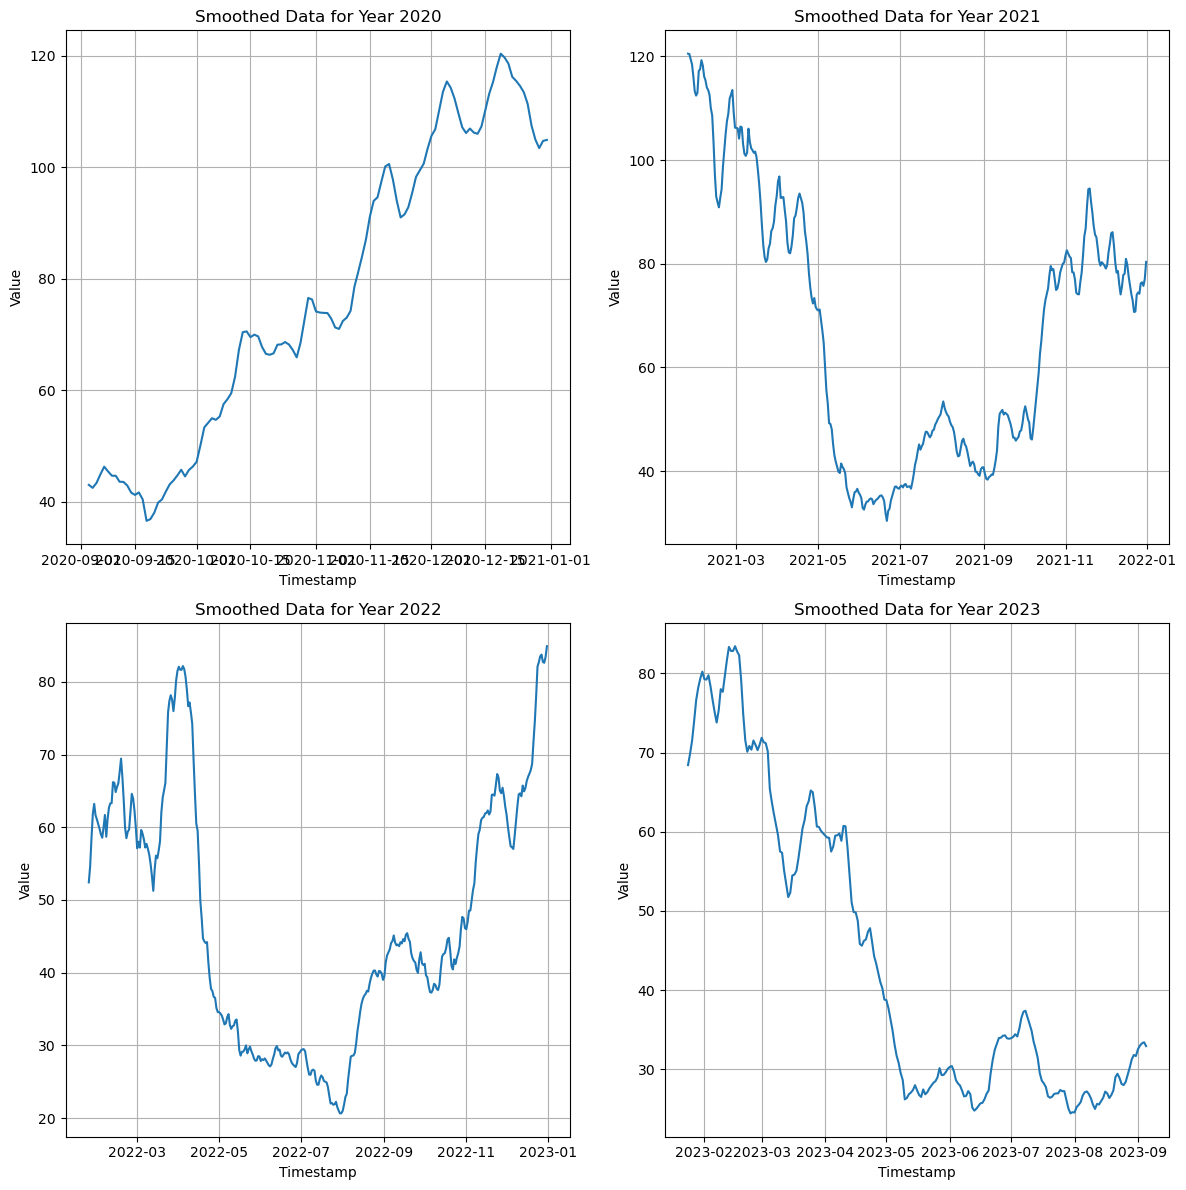

In [95]:

window_size = 24 

years = [2020, 2021, 2022, 2023]
num_years = len(years)
num_rows = (num_years + 1) // 2 
fig, axs = plt.subplots(num_rows, 2, figsize=(12, 6 * num_rows))

for i, year in enumerate(years):
    row = i // 2
    col = i % 2
    
    year_data = daily_data[str(year)]
    
    smoothed_data = year_data.rolling(window=window_size).mean()
    
    axs[row, col].plot(smoothed_data.index, smoothed_data.values)
    axs[row, col].set_title(f'Smoothed Data for Year {year}')
    axs[row, col].set_xlabel('Timestamp')
    axs[row, col].set_ylabel('Value')
    axs[row, col].grid(True)

plt.tight_layout()
plt.show()


It's obvious that there is a seasonal dependency for aqi.

## Test/train split

In [96]:
X_train = aqi_df.loc[(aqi_df['logged_at'] >= '2021-01-01') & (aqi_df['logged_at'] <= '2022-12-31'), 
                             ['device_id', 'phenomenon', 'value', 'logged_at', 'hour', 'month']]
y_train = pm25_df.loc[(pm25_df['logged_at'] >= '2021-01-01') & (pm25_df['logged_at'] <= '2022-12-31'), 
                             ['device_id', 'phenomenon', 'value', 'logged_at', 'hour', 'month']]
X_test = pm25_df[pm25_df['logged_at'].dt.year == 2023]
y_test = pm25_df[pm25_df['logged_at'].dt.year == 2023]

In [97]:
daily_train_data = daily_data['2022']
daily_test_data = daily_data['2023']

In [98]:
monthly_train_data = monthly_data['2021-01-01':'2022-12-31']
monthly_test_data = monthly_data['2022-12-01':'2023-12-31']

## Choosing parameters 

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


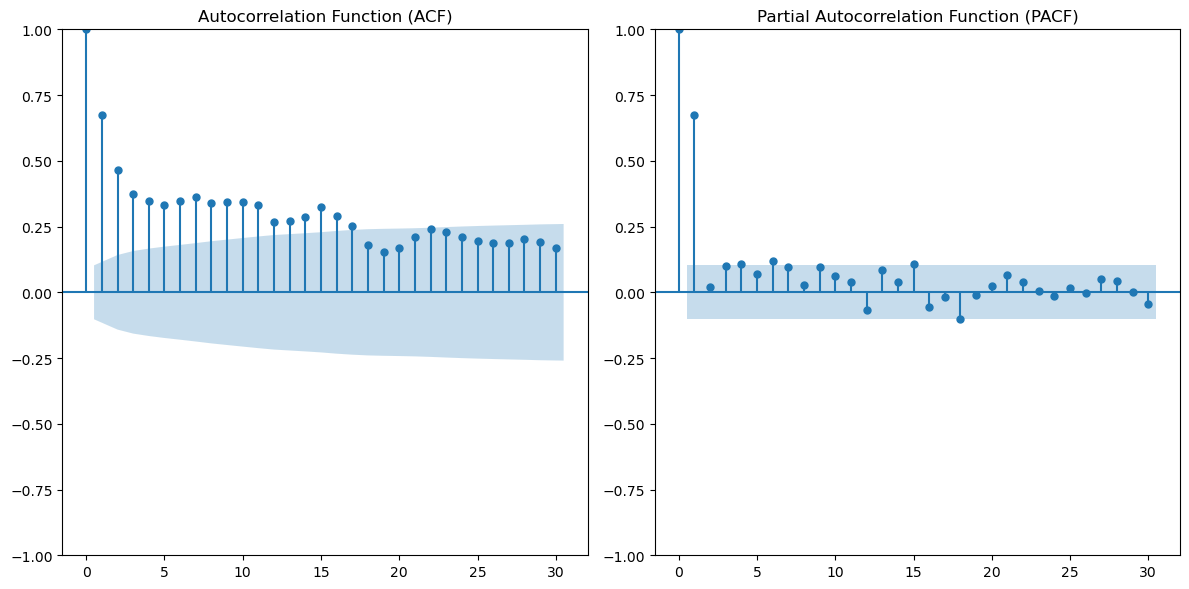

In [99]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_acf(daily_train_data, lags=30, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')
plot_pacf(daily_train_data, lags=30, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()


## ARIMA

An autoregressive integrated moving average, or ARIMA, is a statistical analysis model that uses time series data to either better understand the data set or to predict future trends.
An ARIMA model is defined by its three order parameters, p, d, q. p specifies the number of Autoregressive terms in the model. d specifies the number of differentations applied on the time series values. q specifies the number of Moving Average terms in the model.

### Daily

In [100]:
p, d, q = 3, 0, 2
model = ARIMA(daily_train_data, order=(p, d, q))
model_fit = model.fit()

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [101]:
forecast_steps = len(daily_test_data)
forecast_results = model_fit.predict(start=len(daily_train_data), end=len(daily_train_data) + forecast_steps - 1, typ='levels', dynamic=True)
forecast_values = forecast_results
confidence_intervals = model_fit.get_forecast(steps=forecast_steps).conf_int()
forecast_index = pd.date_range(start='2022-12-01', periods=forecast_steps + len(daily_train_data) - 1, freq='D')
forecast_df = pd.DataFrame({'forecasted_value': forecast_values,
                            'lower_confidence': confidence_intervals.iloc[:, 0],
                            'upper_confidence': confidence_intervals.iloc[:, 1]},
                           index=forecast_index)

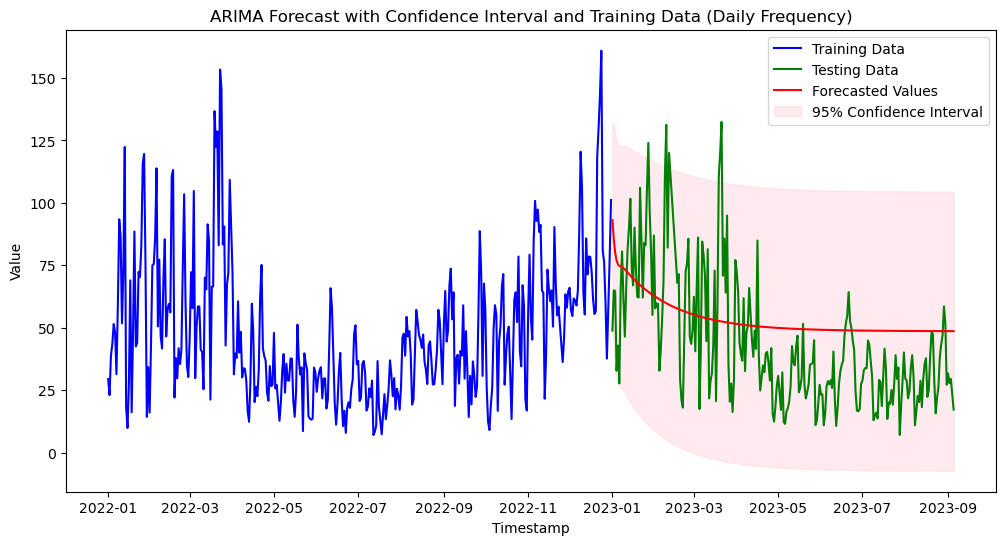

In [102]:
plt.figure(figsize=(12, 6))
plt.plot(daily_train_data, label='Training Data', color='blue')
plt.plot(daily_test_data, label='Testing Data', color='green')
plt.plot(forecast_df.index, forecast_df['forecasted_value'], color='red', label='Forecasted Values')
plt.fill_between(forecast_df.index, forecast_df['lower_confidence'], forecast_df['upper_confidence'], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title('ARIMA Forecast with Confidence Interval and Training Data (Daily Frequency)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

In [103]:
mse = mean_squared_error(daily_test_data, forecast_values)
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 24.95869209437099


### Monthly

In [104]:
p, d, q = 3, 0, 2
model = ARIMA(monthly_train_data, order=(p, d, q))
model_fit = model.fit()

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [105]:
forecast_steps = len(monthly_test_data)
forecast_results = model_fit.predict(start=len(monthly_train_data)-1, end=len(monthly_train_data) + forecast_steps - 2, typ='levels', dynamic=True)
forecast_values = forecast_results
confidence_intervals = model_fit.get_forecast(steps=forecast_steps).conf_int()
forecast_index = pd.date_range(start='2022-12-01', periods=forecast_steps, freq='M')
forecast_df = pd.DataFrame({'forecasted_value': forecast_values,
                            'lower_confidence': confidence_intervals.iloc[:, 0],
                            'upper_confidence': confidence_intervals.iloc[:, 1]},
                           index=forecast_index)
confidence_intervals_index = pd.date_range(start='2022-12-01', periods=forecast_steps, freq='M')
forecast_df['lower_confidence'] = confidence_intervals.iloc[:, 0].values
forecast_df['upper_confidence'] = confidence_intervals.iloc[:, 1].values
forecast_df = forecast_df.set_index(confidence_intervals_index)

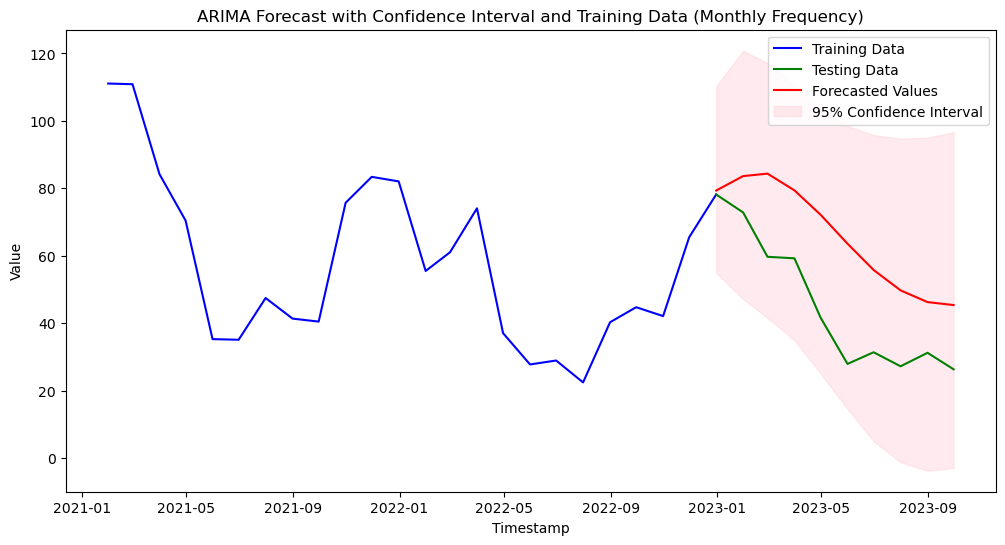

In [106]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_train_data, label='Training Data', color='blue')
plt.plot(monthly_test_data, label='Testing Data', color='green')
plt.plot(forecast_df.index, forecast_df['forecasted_value'], color='red', label='Forecasted Values')
plt.fill_between(forecast_df.index, forecast_df['lower_confidence'], forecast_df['upper_confidence'], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title('ARIMA Forecast with Confidence Interval and Training Data (Monthly Frequency)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()


In [107]:
forecast_index

DatetimeIndex(['2022-12-31', '2023-01-31', '2023-02-28', '2023-03-31',
               '2023-04-30', '2023-05-31', '2023-06-30', '2023-07-31',
               '2023-08-31', '2023-09-30'],
              dtype='datetime64[ns]', freq='M')

In [108]:
mse = mean_squared_error(monthly_test_data, forecast_values)
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 22.413534312272944


In [109]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   24
Model:                 ARIMA(3, 0, 2)   Log Likelihood                 -99.045
Date:                Wed, 13 Sep 2023   AIC                            212.091
Time:                        15:24:57   BIC                            220.337
Sample:                    01-31-2021   HQIC                           214.278
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         57.6196      5.144     11.202      0.000      47.538      67.701
ar.L1          1.0797      0.783      1.379      0.168      -0.455       2.614
ar.L2          0.1002      1.272      0.079      0.937      -2.393       2.594
ar.L3         -0.4466      0.675     -0.662      0.508      -1.769       0.876
ma.L1         -0.2365     42.169     -0.006      0.996     -82.886      82.413
ma.L2         -0.7622     31.776     -0.024      0.981     -63.043      61.518
sigma2       191.6071   8000.245      0.024      0.981   -1.55e+04    1.59e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                 0.41
Prob(Q):                              0.57   Prob(JB):                         0.82
Heteroskedasticity (H):               0.35   Skew:                             0.17
Prob(H) (two-sided):                  0.16   Kurtosis:                         2.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## LR

In [110]:
X_train = np.array(X_train['value']).reshape(-1, 1)
y_train = np.array(y_train['value']).reshape(-1, 1)
X_test = np.array(X_test['value']).reshape(-1, 1)
y_test = np.array(y_test['value']).reshape(-1, 1)

In [111]:
len(y_train)

15940

In [112]:
regr = LinearRegression().fit(X_train, y_train)
y_pred = regr.predict(X_test)

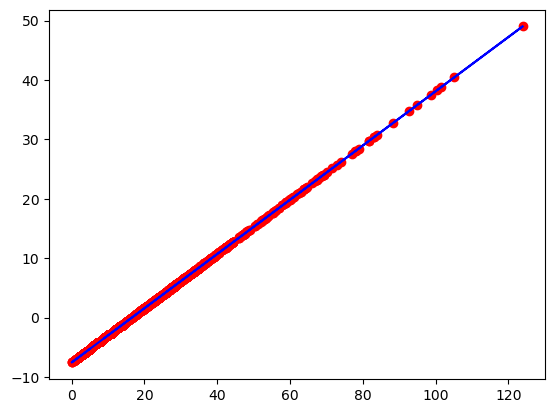

In [113]:
plt.scatter(X_test.flatten(),y_pred.flatten(), color='red') 
plt.plot(X_test, y_pred,color='blue') 

In [114]:
print("Score:", regr.score(X_test, y_test))

Score: -0.8569775406760445


In [115]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 15.488871876381108
